# Modeling Vacancies in a Binary Compound With the Rock Salt Structure

In [1]:
using FreeBird
using Plots
using DataFrames
using CSV
using Distributions

In [2]:
function plot_lattice(lattice::LatticeSystem)
    x = lattice.positions[:, 1]
    y = lattice.positions[:, 2]
    z = lattice.positions[:, 3]
    
    # Create arrays for colors based on adsorption status
    colors = [if lattice.adsorptions[i] "red" else "blue" end for i in 1:length(x)]
    
    # Create the scatter plot for lattice points with hover labels
    hover_labels = [string("Atom ", i) for i in 1:length(x)]
    p = scatter3d(x, y, z, markersize=5, label="Lattice Points", legend=:topright, hover=hover_labels, color=colors)
    
    # Plot the lattice vectors
    origin = [0.0, 0.0, 0.0]
    a1 = lattice.lattice_vectors[:, 1]
    a2 = lattice.lattice_vectors[:, 2]
    a3 = lattice.lattice_vectors[:, 3]
    
    plot!(p, [origin[1], a1[1]], [origin[2], a1[2]], [origin[3], a1[3]], lw=2, label="a1", color=:red)
    plot!(p, [origin[1], a2[1]], [origin[2], a2[2]], [origin[3], a2[3]], lw=2, label="a2", color=:green)
    plot!(p, [origin[1], a3[1]], [origin[2], a3[2]], [origin[3], a3[3]], lw=2, label="a3", color=:blue)
    
    # Optionally, plot the bonds to neighbors
    for (i, (first_neighbors, second_neighbors)) in enumerate(lattice.neighbors)
        for j in first_neighbors
            plot!(p, [x[i], x[j]], [y[i], y[j]], [z[i], z[j]], lw=1, label="", color=:gray)
        end
        # for j in second_neighbors
        #     plot!(p, [x[i], x[j]], [y[i], y[j]], [z[i], z[j]], lw=1, linestyle=:dash, label="", color=:gray)
        # end
    end
    
    display(p)
end

plot_lattice (generic function with 1 method)

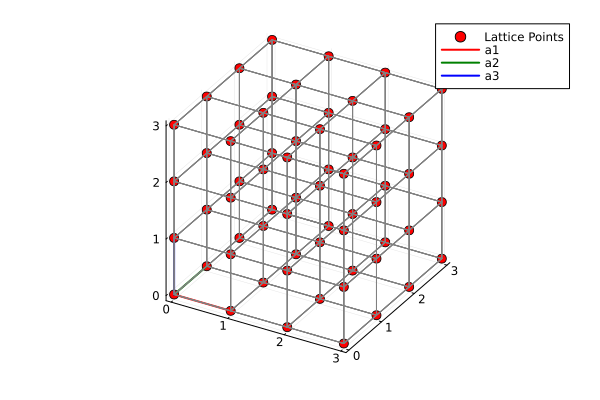

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

In [3]:
a = 1.0  # lattice constant
lattice_vectors = [a 0 0; 0 a 0; 0 0 a]
basis = [(0.0, 0.0, 0.0)]  # B sites
supercell_dimensions = (4, 4, 4)
periodicity = (true, true, true)
num_total_sites = prod(supercell_dimensions)*length(basis)
occupations = [true for i in 1:num_total_sites]
adsorptions = [true for i in 1:num_total_sites]
cutoff_radii = (1.1, 1.5)
lattice = LatticeSystem(
    lattice_vectors,
    basis,
    supercell_dimensions,
    periodicity,
    occupations,
    adsorptions,
    cutoff_radii
)
plot_lattice(lattice)

In [4]:
# Define modeling parameters
K = supercell_dimensions[1]
L = supercell_dimensions[2]
M = supercell_dimensions[3]
Ns = [1, 2, 3]
vacancy_formation_energy = 4.0
nn_interaction_energy = 1.0  # nearest-neighbor vacancy-vacancy interaction energy
nnn_interaction_energy = 0.1  # next-nearest-neighbor vacancy-vacancy interaction energy

0.1

## Exact Enumeration of Vacancies in a Binary Compound With the Rock Salt Structure

In [5]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for exact enumeration
parameters = "exact_vacancy_in_rock_salt_K$(K)_L$(L)_M$(M)_adsorption$(vacancy_formation_energy)_nn$(nn_interaction_energy)_nnn$(nnn_interaction_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
microstates_file = "data/microstates_$parameters.csv"

# Perform exact enumeration if data file does not exist
if !isfile(microstates_file)
    df_microstates = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Any[])

    for N in Ns
        # Perform exact enumeration
        energies, configurations = exact_enumeration(
            lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            N,
            adsorptions,
            vacancy_formation_energy,
            nn_interaction_energy,
            nnn_interaction_energy,
            cutoff_radii
        )

        # Append energy configurations data to DataFrame
        for i in 1:length(energies)
            append!(df_microstates, DataFrame(N = N, K = K, L = L, M = M, energy = energies[i], configurations = configurations[i]))
        end
    end

    # Write DataFrames to CSV files
    CSV.write(microstates_file, df_microstates)
else
    println("Data file already exists")
end

Data file already exists


In [6]:
# Read microstates data from CSV file
df_microstates = CSV.read(microstates_file, DataFrame)

cv_file = "data/Cv_$parameters.csv"
# Calculate heat capacity if data file does not exist
if !isfile(cv_file)
    df_Cv = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[], U = Float64[])

    for N in unique(df_microstates.N)
        # Filter microstates data by N
        df_microstates_N = filter(row -> row.N == N, df_microstates)
        energies = df_microstates_N.energy
        configurations = df_microstates_N.configurations

        # Define temperature range and corresponding beta values
        Ts = collect(1.0:0.1:2000.0)  # temperatures in K
        βs = 1.0 ./ (k_B * Ts)  # 1/eV

        # Prepare energy values for Cv calculation
        ωis = ones(length(energies))
        Eis = [ustrip(energy) for energy in energies]
        dof = 0

        # Calculate Cv for each temperature
        Cv_values = [cv(β, ωis, Eis, dof) / k_B for β in βs]  # Cv in units of kB

        # Calculate U for each temperature
        U_values = [internal_energy(β, ωis, Eis) for β in βs]

        # Append Cv data to DataFrame
        append!(df_Cv, DataFrame(N = N, K = K, L = L, M = M, β = βs, T = Ts, Cv = Cv_values, U = U_values))
    end

    # Write DataFrames to CSV files
    CSV.write(cv_file, df_Cv)
else
    println("Data file already exists")
end

Data file already exists


In [7]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read heat capacity data from CSV file
df_Cv = CSV.read(cv_file, DataFrame)

# Plot internal energy as a function of temperature
p1 = plot()
for N in unique(df_Cv.N)
    df_Cv_N = filter(row -> row.N == N, df_Cv)
    plot!(p1, df_Cv_N.T, df_Cv_N.U ./ N, label="N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")
end

# Plot heat capacity as a function of temperature
p2 = plot()
for N in unique(df_Cv.N)
    df_Cv_N = filter(row -> row.N == N, df_Cv)
    plot!(p2, df_Cv_N.T, df_Cv_N.Cv ./ N, label="N = $N", ylim=(0, 0.2), xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")
end
plot(p1, p2, layout=(2, 1), size=(800, 800))

# Save the plot to a file
plot_file = "figures/plot_$parameters.png"
savefig(plot_file)

"/Users/robertwexler/PycharmProjects/FreeBird.jl/scripts/figures/plot_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.png"

# Markov Chain Monte Carlo (MCMC) Simulation of Vacancies in a Binary Compound With the Rock Salt Structure

In [8]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for MCMC simulation
temperatures = 2000:-50:50
num_equilibration_steps = 10_000
num_sampling_steps = 10_000
random_seed = 1234

# Define file paths for data
parameters = "mc_vacancy_in_rock_salt_K$(K)_L$(L)_M$(M)_adsorption$(vacancy_formation_energy)_nn$(nn_interaction_energy)_nnn$(nnn_interaction_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"

# Perform the Monte Carlo simulation if data files do not exist
if !isfile(cv_file)

    # Initialize a DataFrame to store the results
    df_samples = DataFrame(N = Int[], T = Float64[], E = Float64[], Cv = Float64[], acceptance_rate = Float64[])
    
    # Perform the Monte Carlo simulation
    for N in Ns
        println("N = $N -------------------")

        # Initialize the lattice
        occupations = [false for i in 1:num_total_sites]
        for i in sample(1:length(occupations), N, replace=false)
            occupations[i] = true
        end
        initial_lattice = LatticeSystem(
            lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            occupations,
            adsorptions,
            cutoff_radii
        )

        for temp in temperatures
            println("T = $temp")

            # Equilibrate the lattice
            temperature = Float64(temp)
            equilibration_energies, equilibration_configurations, equilibration_accepted_steps = nvt_monte_carlo(
                initial_lattice,
                vacancy_formation_energy,
                nn_interaction_energy,
                nnn_interaction_energy,
                temperature,
                num_equilibration_steps,
                random_seed
            )

            # Sample the lattice
            sampling_energies, sampling_configurations, sampling_accepted_steps = nvt_monte_carlo(
                equilibration_configurations[end],
                vacancy_formation_energy,
                nn_interaction_energy,
                nnn_interaction_energy,
                temperature,
                num_sampling_steps,
                random_seed
            )

            # Compute the heat capacity
            E = mean(sampling_energies)
            Cv = var(sampling_energies) / (k_B * temperature^2)

            # Compute the acceptance rate
            acceptance_rate = sampling_accepted_steps / num_sampling_steps

            # Append the results to the DataFrame
            append!(df_samples, DataFrame(N = N, T = temperature, E = E, Cv = Cv, acceptance_rate = acceptance_rate))

            # Update the initial lattice
            initial_lattice = deepcopy(sampling_configurations[end])
        end
    end

    # Write DataFrame to a CSV file
    CSV.write(cv_file, df_samples)
else
    println("Data files already exist.")
end

Data files already exist.


In [9]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read heat capacity data from CSV file
df_Cv_exact = CSV.read("data/Cv_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
df_Cv_mcmc = CSV.read("data/Cv_mc_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)

Ns = [3]

# Plot internal energy as a function of temperature
p1 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    plot!(p1, df_Cv_N_exact.T, df_Cv_N_exact.U ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)", color=N)
    plot!(p1, df_Cv_N_mcmc.T, df_Cv_N_mcmc.E ./ N, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)", color=N, linestyle=:dash)
end

# Plot heat capacity as a function of temperature
p2 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    plot!(p2, df_Cv_N_exact.T, df_Cv_N_exact.Cv ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)", color=N)
    plot!(p2, df_Cv_N_mcmc.T, df_Cv_N_mcmc.Cv ./ N / k_B, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)", color=N, linestyle=:dash)
end
plot!(p2, ylim=(0, 0.2))

plot(p1, p2, layout=(2, 1), size=(800, 800))

# Save the plot to a file
plot_file = "figures/plot_$parameters.png"
savefig(plot_file)

"/Users/robertwexler/PycharmProjects/FreeBird.jl/scripts/figures/plot_mc_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.png"

## Wang-Landau Algorithm for Modeling Vacancies in a Binary Compound With the Rock Salt Structure

In [58]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for Wang-Landau simulation
num_steps = 400
flatness_criterion = 0.8
f_initial = Float64(MathConstants.e)
f_min = exp(10^-8)
energy_min = 12.0
energy_max = 14.1
num_energy_bins = 211
energy_bins = collect(range(energy_min, stop=energy_max, length=num_energy_bins))

# Initialize the lattice
occupations = [false for i in 1:num_total_sites]
for i in sample(1:length(occupations), 3, replace=false)
    occupations[i] = true
end
initial_lattice = LatticeSystem(
    lattice_vectors,
    basis,
    supercell_dimensions,
    periodicity,
    occupations,
    adsorptions,
    cutoff_radii
)

# Define file paths for data
parameters = "wl_vacancy_in_rock_salt_K$(K)_L$(L)_M$(M)_adsorption$(vacancy_formation_energy)_nn$(nn_interaction_energy)_nnn$(nnn_interaction_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
entropy_file = "data/entropy_$parameters.csv"

# Perform the Wang-Landau simulation if data files do not exist
if !isfile(entropy_file)
    entropy, histogram, bin_energies, energies, configurations = wang_landau(
        initial_lattice,
        vacancy_formation_energy,
        nn_interaction_energy,
        nnn_interaction_energy,
        num_steps,
        flatness_criterion,
        f_initial,
        f_min,
        energy_bins,
        random_seed
    )

    # Write the entropy to a CSV file
    df_entropy = DataFrame(energy = bin_energies, entropy = entropy)
    CSV.write(entropy_file, df_entropy)
else
    println("Data files already exist.")
end

f = 1.6487212707001282
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.2840254166877414
f = 1.1331484530668263
f = 1.1331484530668263
f = 1.0644944589178595
f = 1.0644944589178595
f = 1.0644944589178595
f = 1.0317434074991028
f = 1.0317434074991028
f = 1.0317434074991028
f = 1.0317434074991028
f = 1.0157477085866857
f = 1.0157477085866857
f = 1.0157477085866857
f = 1.007843097206448
f = 1.007843097206448
f = 1.007843097206448
f = 1.007843097206448
f = 1.007843097206448
f = 1.0039138893383477
f = 1.0039138893383477
f = 1.0039138893383477
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0019550335910028
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394924165
f = 1.0009770394

"data/entropy_wl_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv"

In [87]:
function compute_heat_capacity_vs_temperature_wl(filename::String)
    # Read data
    df_wl = CSV.read(filename, DataFrame)
    S_shifted = df_wl.entropy .- minimum(df_wl.entropy[df_wl.entropy .> 0])
    g = exp.(S_shifted)
    E = df_wl.energy

    # Compute the partition function as a function of temperature
    E_rel = E .- minimum(E)
    T = collect(1.0:0.1:2000.0)
    Z = zeros(length(T))
    for (i, temp) in enumerate(T)
        Z[i] = sum(exp.(-E_rel ./ (k_B * temp)) .* g)
    end

    # Compute the average energy as a function of temperature
    E_avg = zeros(length(T))
    for (i, temp) in enumerate(T)
        E_avg[i] = sum(E_rel .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
    end

    # Compute the average energy squared as a function of temperature
    E2_avg = zeros(length(T))
    for (i, temp) in enumerate(T)
        E2_avg[i] = sum(E_rel.^2 .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
    end

    # Compute the heat capacity as a function of temperature
    Cv = (E2_avg .- E_avg.^2) ./ (k_B * T.^2) / k_B

    # Return the results as a DataFrame
    return DataFrame(T = T, Cv = Cv, U = E_avg .+ minimum(E))
end

function compute_heat_capacity_vs_temperature_ns(filename::String, num_walkers::Int, num_steps::Int)
    # Read data
    df_ns = CSV.read(filename, DataFrame)

    # Compute ω_i
    ω_0 = 64 * 63 * 62 / 3 / 2 / 1  # 64 choose 3
    ω_i = ω_0 * (1 / num_walkers) * (num_walkers / (num_walkers + 1)) .^ (collect(1:num_steps))

    # Temperature range
    T = collect(1.0:0.1:2000.0)
    
    # Compute the partition function as a function of temperature
    Z = zeros(length(T))
    E_i_ns = df_ns.energy
    E_rel_i_ns = E_i_ns .- minimum(E_i_ns)
    for (i, temp) in enumerate(T)
        Z[i] = sum(exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i)
    end

    # Compute the average energy as a function of temperature
    E_avg_i_ns = zeros(length(T))
    for (i, temp) in enumerate(T)
        E_avg_i_ns[i] = sum(E_rel_i_ns .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
    end

    # Compute the average energy squared as a function of temperature
    E2_avg_i_ns = zeros(length(T))
    for (i, temp) in enumerate(T)
        E2_avg_i_ns[i] = sum(E_rel_i_ns.^2 .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
    end

    # Compute the heat capacity as a function of temperature
    Cv_i_ns = (E2_avg_i_ns .- E_avg_i_ns.^2) ./ (k_B * T.^2) / k_B

    # Return the results as a DataFrame
    return DataFrame(T = T, Cv = Cv_i_ns, U = E_avg_i_ns .+ minimum(E_i_ns))
end

compute_heat_capacity_vs_temperature_ns (generic function with 1 method)

In [88]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read heat capacity data from CSV file
df_Cv_exact = CSV.read("data/Cv_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
df_Cv_mcmc = CSV.read("data/Cv_mc_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
df_Cv_wl = compute_heat_capacity_vs_temperature_wl("data/entropy_wl_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv")

Ns = [3]

# Plot internal energy as a function of temperature
p1 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    df_Cv_N_wl = deepcopy(df_Cv_wl)
    plot!(p1, df_Cv_N_exact.T, df_Cv_N_exact.U ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N)
    plot!(p1, df_Cv_N_mcmc.T, df_Cv_N_mcmc.E ./ N, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
    # plot!(p1, df_Cv_N_wl.T, df_Cv_N_wl.U ./ N, label="Wang-Landau N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
end

# Plot heat capacity as a function of temperature
p2 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    df_Cv_N_wl = deepcopy(df_Cv_wl)
    plot!(p2, df_Cv_N_exact.T, df_Cv_N_exact.Cv ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N)
    plot!(p2, df_Cv_N_mcmc.T, df_Cv_N_mcmc.Cv ./ N / k_B, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
    plot!(p2, df_Cv_N_wl.T, df_Cv_N_wl.Cv ./ N, label="Wang-Landau N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
end
plot!(p2, ylim=(0, 0.2))

plot(p1, p2, layout=(2, 1), size=(800, 800))

# Save the plot to a file
plot_file = "figures/plot_$parameters.png"
savefig(plot_file)

"/Users/robertwexler/PycharmProjects/FreeBird.jl/scripts/figures/plot_ns_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.png"

## Nested Sampling for Modeling Vacancies in a Binary Compound With the Rock Salt Structure

Data files already exist.


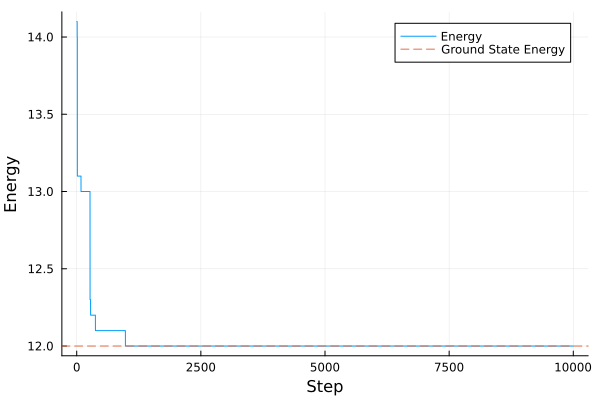

In [89]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Initialize walkers with random configurations
num_walkers = 1000
walkers = [deepcopy(initial_lattice) for i in 1:num_walkers]
for walker in walkers
    walker.occupations = [false for i in 1:length(walker.occupations)]
    for i in sample(1:length(walker.occupations), 3, replace=false)
        walker.occupations[i] = true
    end
end

# Define parameters for nested sampling simulation
num_steps = 10000
perturbation = 1e-10

# Define file paths for data
parameters = "ns_vacancy_in_rock_salt_K$(K)_L$(L)_M$(M)_adsorption$(vacancy_formation_energy)_nn$(nn_interaction_energy)_nnn$(nnn_interaction_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
energy_file = "data/energy_$parameters.csv"

# Perform the nested sampling simulation if data files do not exist
if !isfile(energy_file)
    results = nested_sampling(
        walkers,
        num_steps,
        vacancy_formation_energy,
        nn_interaction_energy,
        nnn_interaction_energy,
        perturbation
    )

    # Write the energy to a CSV file
    df_energy = DataFrame(step = 1:num_steps, energy = results[3])
    CSV.write(energy_file, df_energy)
else
    println("Data files already exist.")
end

# Plot the results
df_ns = CSV.read(energy_file, DataFrame)
plot(df_ns.energy, xlabel="Step", ylabel="Energy", label="Energy")

# Add a horizontal line for the ground state energy
ground_state_energy = 12.0
hline!([ground_state_energy], label="Ground State Energy", linestyle=:dash)

In [90]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read heat capacity data from CSV file
df_Cv_exact = CSV.read("data/Cv_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
df_Cv_mcmc = CSV.read("data/Cv_mc_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
df_Cv_wl = compute_heat_capacity_vs_temperature_wl("data/entropy_wl_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv")
df_Cv_ns = compute_heat_capacity_vs_temperature_ns("data/energy_ns_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", num_walkers, num_steps)

Ns = [3]

# Plot internal energy as a function of temperature
p1 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    df_Cv_N_wl = deepcopy(df_Cv_wl)
    df_Cv_N_ns = deepcopy(df_Cv_ns)
    plot!(p1, df_Cv_N_exact.T, df_Cv_N_exact.U ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N)
    plot!(p1, df_Cv_N_mcmc.T, df_Cv_N_mcmc.E ./ N, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
    plot!(p1, df_Cv_N_wl.T, df_Cv_N_wl.U ./ N, label="Wang-Landau N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
    plot!(p1, df_Cv_N_ns.T, df_Cv_N_ns.U ./ N, label="Nested Sampling N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
end

# Plot heat capacity as a function of temperature
p2 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    df_Cv_N_wl = deepcopy(df_Cv_wl)
    df_Cv_N_ns = deepcopy(df_Cv_ns)
    plot!(p2, df_Cv_N_exact.T, df_Cv_N_exact.Cv ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N)
    plot!(p2, df_Cv_N_mcmc.T, df_Cv_N_mcmc.Cv ./ N / k_B, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
    plot!(p2, df_Cv_N_wl.T, df_Cv_N_wl.Cv ./ N, label="Wang-Landau N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
    plot!(p2, df_Cv_N_ns.T, df_Cv_N_ns.Cv ./ N, label="Nested Sampling N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")  # , color=N, linestyle=:dash)
end
plot!(p2, ylim=(0, 0.2))

plot(p1, p2, layout=(2, 1), size=(800, 800))

# Save the plot to a file
plot_file = "figures/plot_$parameters.png"
savefig(plot_file)

"/Users/robertwexler/PycharmProjects/FreeBird.jl/scripts/figures/plot_ns_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.png"

## Compute the Free Energy of Vacancies in a Binary Compound With the Rock Salt Structure

In [97]:
function compute_free_energy_wl(filename::String)
    # Read data
    df_wl = CSV.read(filename, DataFrame)
    S_shifted = df_wl.entropy .- minimum(df_wl.entropy[df_wl.entropy .> 0])
    g = exp.(S_shifted)
    E = df_wl.energy

    # Compute the partition function as a function of temperature
    E_rel = E .- minimum(E)
    T = collect(1.0:0.1:2000.0)
    Z = zeros(length(T))
    for (i, temp) in enumerate(T)
        Z[i] = sum(exp.(-E_rel ./ (k_B * temp)) .* g)
    end

    # Compute the average energy as a function of temperature
    E_avg = zeros(length(T))
    for (i, temp) in enumerate(T)
        E_avg[i] = sum(E_rel .* exp.(-E_rel ./ (k_B * temp)) .* g) / Z[i]
    end
    U = E_avg .+ minimum(E)

    # Compute the free energy as a function of temperature
    F = -k_B .* T .* log.(Z) .+ minimum(E)

    # Compute the entropy as a function of temperature
    S = (U .- F) ./ T

    # Return the results as a DataFrame
    return DataFrame(T = T, Z = Z, U = U, F = F, S = S)
end

function compute_free_energy_ns(filename::String, num_walkers::Int, num_steps::Int)
    # Read data
    df_ns = CSV.read(filename, DataFrame)

    # Compute ω_i
    ω_0 = 64 * 63 * 62 / 3 / 2 / 1  # 64 choose 3
    ω_i = ω_0 * (1 / num_walkers) * (num_walkers / (num_walkers + 1)) .^ (collect(1:num_steps))

    # Temperature range
    T = collect(1.0:0.1:2000.0)
    
    # Compute the partition function as a function of temperature
    Z = zeros(length(T))
    E_i_ns = df_ns.energy
    E_rel_i_ns = E_i_ns .- minimum(E_i_ns)
    for (i, temp) in enumerate(T)
        Z[i] = sum(exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i)
    end

    # Compute the average energy as a function of temperature
    E_avg_i_ns = zeros(length(T))
    for (i, temp) in enumerate(T)
        E_avg_i_ns[i] = sum(E_rel_i_ns .* exp.(-E_rel_i_ns ./ (k_B * temp)) .* ω_i) / Z[i]
    end
    U = E_avg_i_ns .+ minimum(E_i_ns)

    # Compute the free energy as a function of temperature
    F = -k_B .* T .* log.(Z) .+ minimum(E_i_ns)

    # Compute the entropy as a function of temperature
    S = (U .- F) ./ T

    # Return the results as a DataFrame
    return DataFrame(T = T, Z = Z, U = U, F = F, S = S)
end

compute_free_energy_ns (generic function with 1 method)

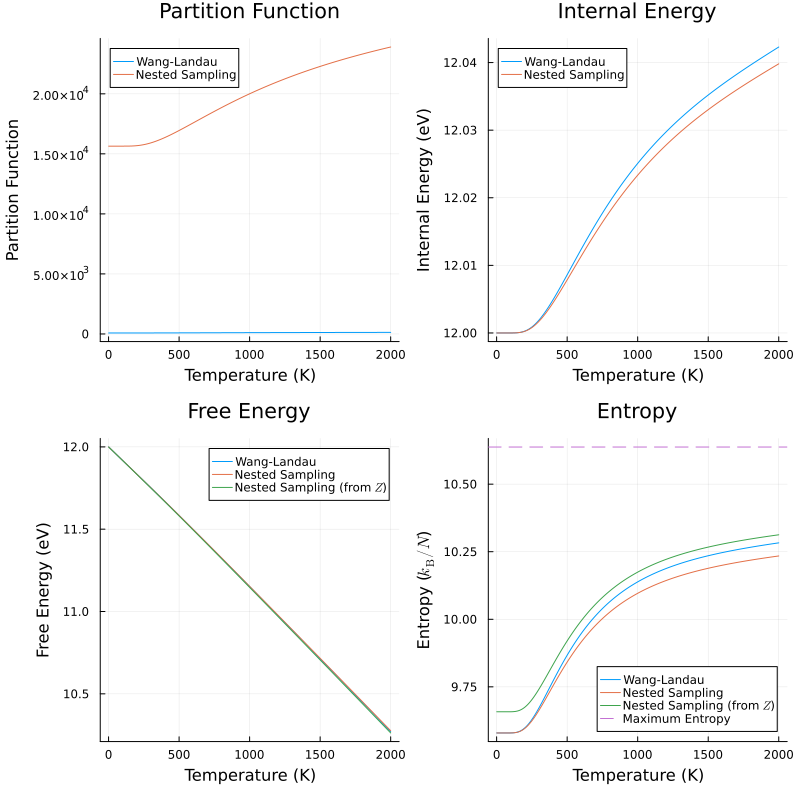

In [118]:
df_F_wl = compute_free_energy_wl("data/entropy_wl_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv")
df_F_ns = compute_free_energy_ns("data/energy_ns_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", num_walkers, num_steps)

# Plot the partition function as a function of temperature
p1 = plot(df_F_wl.T, df_F_wl.Z, xlabel="Temperature (K)", ylabel="Partition Function", title="Partition Function", label="Wang-Landau")
plot!(p1, df_F_ns.T, df_F_ns.Z, xlabel="Temperature (K)", ylabel="Partition Function", title="Partition Function", label="Nested Sampling")

# Plot the internal energy as a function of temperature
p2 = plot(df_F_wl.T, df_F_wl.U, xlabel="Temperature (K)", ylabel="Internal Energy (eV)", title="Internal Energy", label="Wang-Landau")
plot!(p2, df_F_ns.T, df_F_ns.U, xlabel="Temperature (K)", ylabel="Internal Energy (eV)", title="Internal Energy", label="Nested Sampling")

# Plot the entropy as a function of temperature
p4 = plot(df_F_wl.T, (df_F_wl.S .- minimum(df_F_wl.S) .+ k_B * log(14464)) ./ k_B, xlabel="Temperature (K)", ylabel="Entropy (\$ k_{\\mathrm{B}} / N \$)", title="Entropy", label="Wang-Landau")
# p4 = plot(df_F_wl.T, df_F_wl.S, xlabel="Temperature (K)", ylabel="Entropy (\$ k_{\\mathrm{B}} / N \$)", title="Entropy", label="Wang-Landau")
plot!(p4, df_F_ns.T, (df_F_ns.S .- minimum(df_F_ns.S) .+ k_B * log(14464)) ./ k_B, xlabel="Temperature (K)", ylabel="Entropy (\$ k_{\\mathrm{B}} / N \$)", title="Entropy", label="Nested Sampling")
plot!(p4, df_F_ns.T, df_F_ns.S ./ k_B, xlabel="Temperature (K)", ylabel="Entropy (\$ k_{\\mathrm{B}} / N \$)", title="Entropy", label="Nested Sampling (from \$ Z \$)")

# Plot the maximum entropy as a horizontal line
hline!([log(64 * 63 * 62 / 3 / 2 / 1)], label="Maximum Entropy", linestyle=:dash)

# Plot the free energy as a function of temperature
p3 = plot(df_F_wl.T, df_F_wl.U .- df_F_wl.T .* (df_F_wl.S .- minimum(df_F_wl.S) .+ k_B * log(14464)), xlabel="Temperature (K)", ylabel="Free Energy (eV)", title="Free Energy", label="Wang-Landau")
# p3 = plot(df_F_wl.T, df_F_wl.F, xlabel="Temperature (K)", ylabel="Free Energy (\$ k_{\\mathrm{B}} / N \$)", title="Free Energy", label="Wang-Landau")
plot!(p3, df_F_ns.T, df_F_ns.U .- df_F_ns.T .* (df_F_ns.S .- minimum(df_F_ns.S) .+ k_B * log(14464)), xlabel="Temperature (K)", ylabel="Free Energy (eV)", title="Free Energy", label="Nested Sampling")
plot!(p3, df_F_ns.T, df_F_ns.F, xlabel="Temperature (K)", ylabel="Free Energy (eV)", title="Free Energy", label="Nested Sampling (from \$ Z \$)")

plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 800))

In [86]:
df_microstates = CSV.read("data/microstates_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
# filter N=3
df_microstates_N3 = filter(row -> row.N == 3, df_microstates)
min_energy = minimum(df_microstates_N3.energy)
# rows where energy is minimum
df_microstates_N3_min_energy = filter(row -> row.energy == min_energy, df_microstates_N3)
# number of rows
num_rows = nrow(df_microstates_N3_min_energy)

14464